In [1]:
%%capture
%pip install seaborn

In [2]:
from collections import defaultdict
import logging
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import pandas as pd
import os


sns.set_theme(
    context="notebook",
    style="ticks",
    font_scale=1.8,
    rc={"figure.dpi": 300, "figure.constrained_layout.use": True,
        "lines.linewidth": 3, "figure.figsize": (6, 3)},
)

In [3]:
def load_single_results(data_path):
    with open(data_path, 'r') as f:
        data = json.load(f)
    return data

In [4]:
def compute_avg_dice(dice_count_list: list[tuple]):
    total_dice = 0
    total_count = 0
    for dice, count in dice_count_list:
        total_dice += dice * count
        total_count += count
    return total_dice / total_count

def get_dice_for_keys(dices: dict, counts: dict,
                      datasets:list = 'all', modalities:list = 'all', tasks:list = 'all',
                      excl_datasets:list = [], excl_modalities:list = [], excl_tasks:list = []):
    # both dices and counts are nested dictionaries:
    # dataset -> modality -> task : dice score / count of samples found
    datasets = [data.lower() for data in datasets] if datasets != 'all' else datasets
    modalities = [mod.lower() for mod in modalities] if modalities != 'all' else modalities
    tasks = [task.lower() for task in tasks] if tasks != 'all' else tasks
    all_levels = []
    data_level = defaultdict(list)
    modality_level = defaultdict(list)
    task_level = defaultdict(list)
    for data_key, mod_data in dices.items():
        for modality, task_data in mod_data.items():
            for task, dice in task_data.items():
                count = counts[data_key][modality][task]
                canload = ((datasets == 'all' or data_key.lower() in datasets) and
                    (modalities == 'all' or modality.lower() in modalities) and
                    (tasks == 'all' or task.lower() in tasks) and
                    (data_key.lower() not in excl_datasets) and
                    (modality.lower() not in excl_modalities) and
                    (task.lower() not in excl_tasks))
                logging.debug('{} using info from dataset {} modality {} task {}: dice {} count {}'\
                              .format(canload, data_key, modality, task, dice, count))
                if canload:
                    all_levels.append((dice, count))
                    data_level[data_key].append((dice, count))
                    modality_level[modality].append((dice, count))
                    task_level[task].append((dice, count))
    # compute scores
    all_dice = compute_avg_dice(all_levels)
    data_dice = {key: compute_avg_dice(value) for key, value in data_level.items()}
    modality_dice = {key: compute_avg_dice(value) for key, value in modality_level.items()}
    task_dice = {key: compute_avg_dice(value) for key, value in task_level.items()}
    return all_dice, data_dice, modality_dice, task_dice


In [5]:
def compute_aggregates(data: dict,
                       datasets:list = 'all', modalities:list = 'all', tasks:list = 'all',
                       excl_datasets:list = [], excl_modalities:list = [], excl_tasks:list = []):
    
    all_levels, data_level, modality_level, task_level = get_dice_for_keys(
        data['per_dataset_modality_task_dice'], data['per_dataset_modality_task_counts'])
    return {
        'all': all_levels,
        **{data_name: data_dice for data_name, data_dice in data_level.items()},
        **{modality_name: modality_dice for modality_name, modality_dice in modality_level.items()},
        **{task_name: task_dice for task_name, task_dice in task_level.items()},
        'data_keys': list(data_level.keys()),
        'modality_keys': list(modality_level.keys()),
        'task_keys': list(task_level.keys())
    }

In [6]:
def merge_results(pattern):
    import glob
    data = {}
    for f in glob.glob(pattern):
        resdata = load_single_results(f)
        if len(data) == 0:
            data = resdata
            continue
        for field in ['per_dataset_modality_task_dice', 'per_dataset_modality_task_counts']:
            for dataset, dataset_data in resdata[field].items():
                if dataset not in data[field]:
                    data[field][dataset] = {}
                for modality, modality_data in dataset_data.items():
                    if modality not in data[field][dataset]:
                        data[field][dataset][modality] = {}
                    for task, task_data in modality_data.items():
                        data[field][dataset][modality][task] = task_data
    return data

# context_ablations = merge_results('results/ex_context*.json')

In [7]:
def print_text_report(aggregated_dict:dict, title):
    print(title)
    print('dice:', aggregated_dict)
    print()
    print('Datasets')
    for data_key in aggregated_dict['data_keys']:
        print('  - {}: {}'.format(data_key, aggregated_dict[data_key]))
    print()
    print('Modalities')
    for modality_key in aggregated_dict['modality_keys']:
        print('  - {}: {}'.format(modality_key, aggregated_dict[modality_key]))
    print()
    print('Tasks')
    for task_key in aggregated_dict['task_keys']:
        print('  - {}: {}'.format(task_key, aggregated_dict[task_key]))


In [8]:
# BASELINE RESULTS
data_path = '../results/results_baseline.json'
baseline_data = load_single_results(data_path)
baseline_all_d = compute_aggregates(baseline_data)
print_text_report(baseline_all_d, 'Baseline results')

Baseline results
dice: {'all': 0.6295535446077153, '0000 Dataset': 0.9618050456047058, '0001 Dataset': 0.583496676882108, '0020 Dataset': 0.7776888310909271, '0008 Dataset': 0.8123207688331604, 'CT': 0.6295535446077153, 'liver': 0.9549267368931924, 'OpticChiasm': 0.1755075752735138, 'Parotid_R': 0.7951778769493103, 'Lips': 0.6662173271179199, 'BuccalMucosa': 0.6360491514205933, 'Glnd_Lacrimal_R': 0.4904055595397949, 'Cricopharyngeus': 0.5694500803947449, 'Bone_Mandible': 0.9151379466056824, 'Esophagus_S': 0.6004030108451843, 'Eye_PR': 0.8163533806800842, 'Arytenoid': 0.132841095328331, 'Glnd_Lacrimal_L': 0.3634571433067322, 'OpticNrv_R': 0.3447383642196655, 'Cochlea_L': 0.2100144475698471, 'Eye_AR': 0.5127241611480713, 'Glnd_Submand_L': 0.7903439402580261, 'Glnd_Thyroid': 0.7892332077026367, 'Larynx_SG': 0.6949116587638855, 'Cavity_Oral': 0.8654983043670654, 'Cochlea_R': 0.26442086696624756, 'Glottis': 0.452264666557312, 'Parotid_L': 0.8029846549034119, 'SpinalCord': 0.7335789799690247

In [9]:
# 400 prompt type ablations
prompt_ablations = {
    'Baseline': {
        'Text & Point': {
            'path': '../results/400_ablations/base_text_point.json'
        },
        'Text & Bounding Box': {
            'path': '../results/400_ablations/base_text_bbox.json'
        },
        'Text': {
            'path': '../results/400_ablations/base_text.json'
        },
        'Point': {
            'path': '../results/400_ablations/base_point.json'
        },
        'Bounding Box': {
            'path': '../results/400_ablations/base_bbox.json'
        }
    },
    'Context Prior': {
        'Text & Point': {
            'path': '../results/400_ablations/context_text_point.json'
        },
        'Text & Bounding Box': {
            'path': '../results/400_ablations/context_text_bbox.json'
        },
        'Text': {
            'path': '../results/400_ablations/context_text.json'
        },
        'Point': {
            'path': '../results/400_ablations/context_point.json'
        },
        'Bounding Box': {
            'path': '../results/400_ablations/context_bbox.json'
        }
    },
    'LoRA': {
        'Text & Point': {
            'path': '../results/400_ablations/lora_text_point.json'
        },
        'Text & Bounding Box': {
            'path': '../results/400_ablations/lora_text_bbox.json'
        },
        'Text': {
            'path': '../results/400_ablations/lora_text.json'
        },
        'Point': {
            'path': '../results/400_ablations/lora_point.json'
        },
        'Bounding Box': {
            'path': '../results/400_ablations/lora_bbox.json'
        }
    }
}

In [10]:
# for each ablation experiment, load the corresponding data file
for model_type in prompt_ablations.keys():
    print('processing model type {}'.format(model_type))
    for prompt_type in prompt_ablations[model_type]:
        if not os.path.exists(prompt_ablations[model_type][prompt_type]['path']):
            print('  file not found:', prompt_ablations[model_type][prompt_type]['path'])
            continue
        print('  processing prompt type {}'.format(prompt_type))
        data_path = prompt_ablations[model_type][prompt_type]['path']
        prompt_ablations[model_type][prompt_type]['data'] = load_single_results(data_path)
        prompt_ablations[model_type][prompt_type]['aggregated'] = compute_aggregates(prompt_ablations[model_type][prompt_type]['data'])

processing model type Baseline
  processing prompt type Text & Point
  processing prompt type Text & Bounding Box
  processing prompt type Text
  processing prompt type Point
  processing prompt type Bounding Box
processing model type Context Prior
  processing prompt type Text & Point
  processing prompt type Text & Bounding Box
  processing prompt type Text
  file not found: ../results/400_ablations/context_point.json
  file not found: ../results/400_ablations/context_bbox.json
processing model type LoRA
  processing prompt type Text & Point
  processing prompt type Text & Bounding Box
  processing prompt type Text
  processing prompt type Point
  processing prompt type Bounding Box


/var/folders/1x/7k25rxt159j8lx18by4r5yhm0000gn/T/ipykernel_44818/3712944848.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([pt for pt, _ in base_dices], rotation=0)


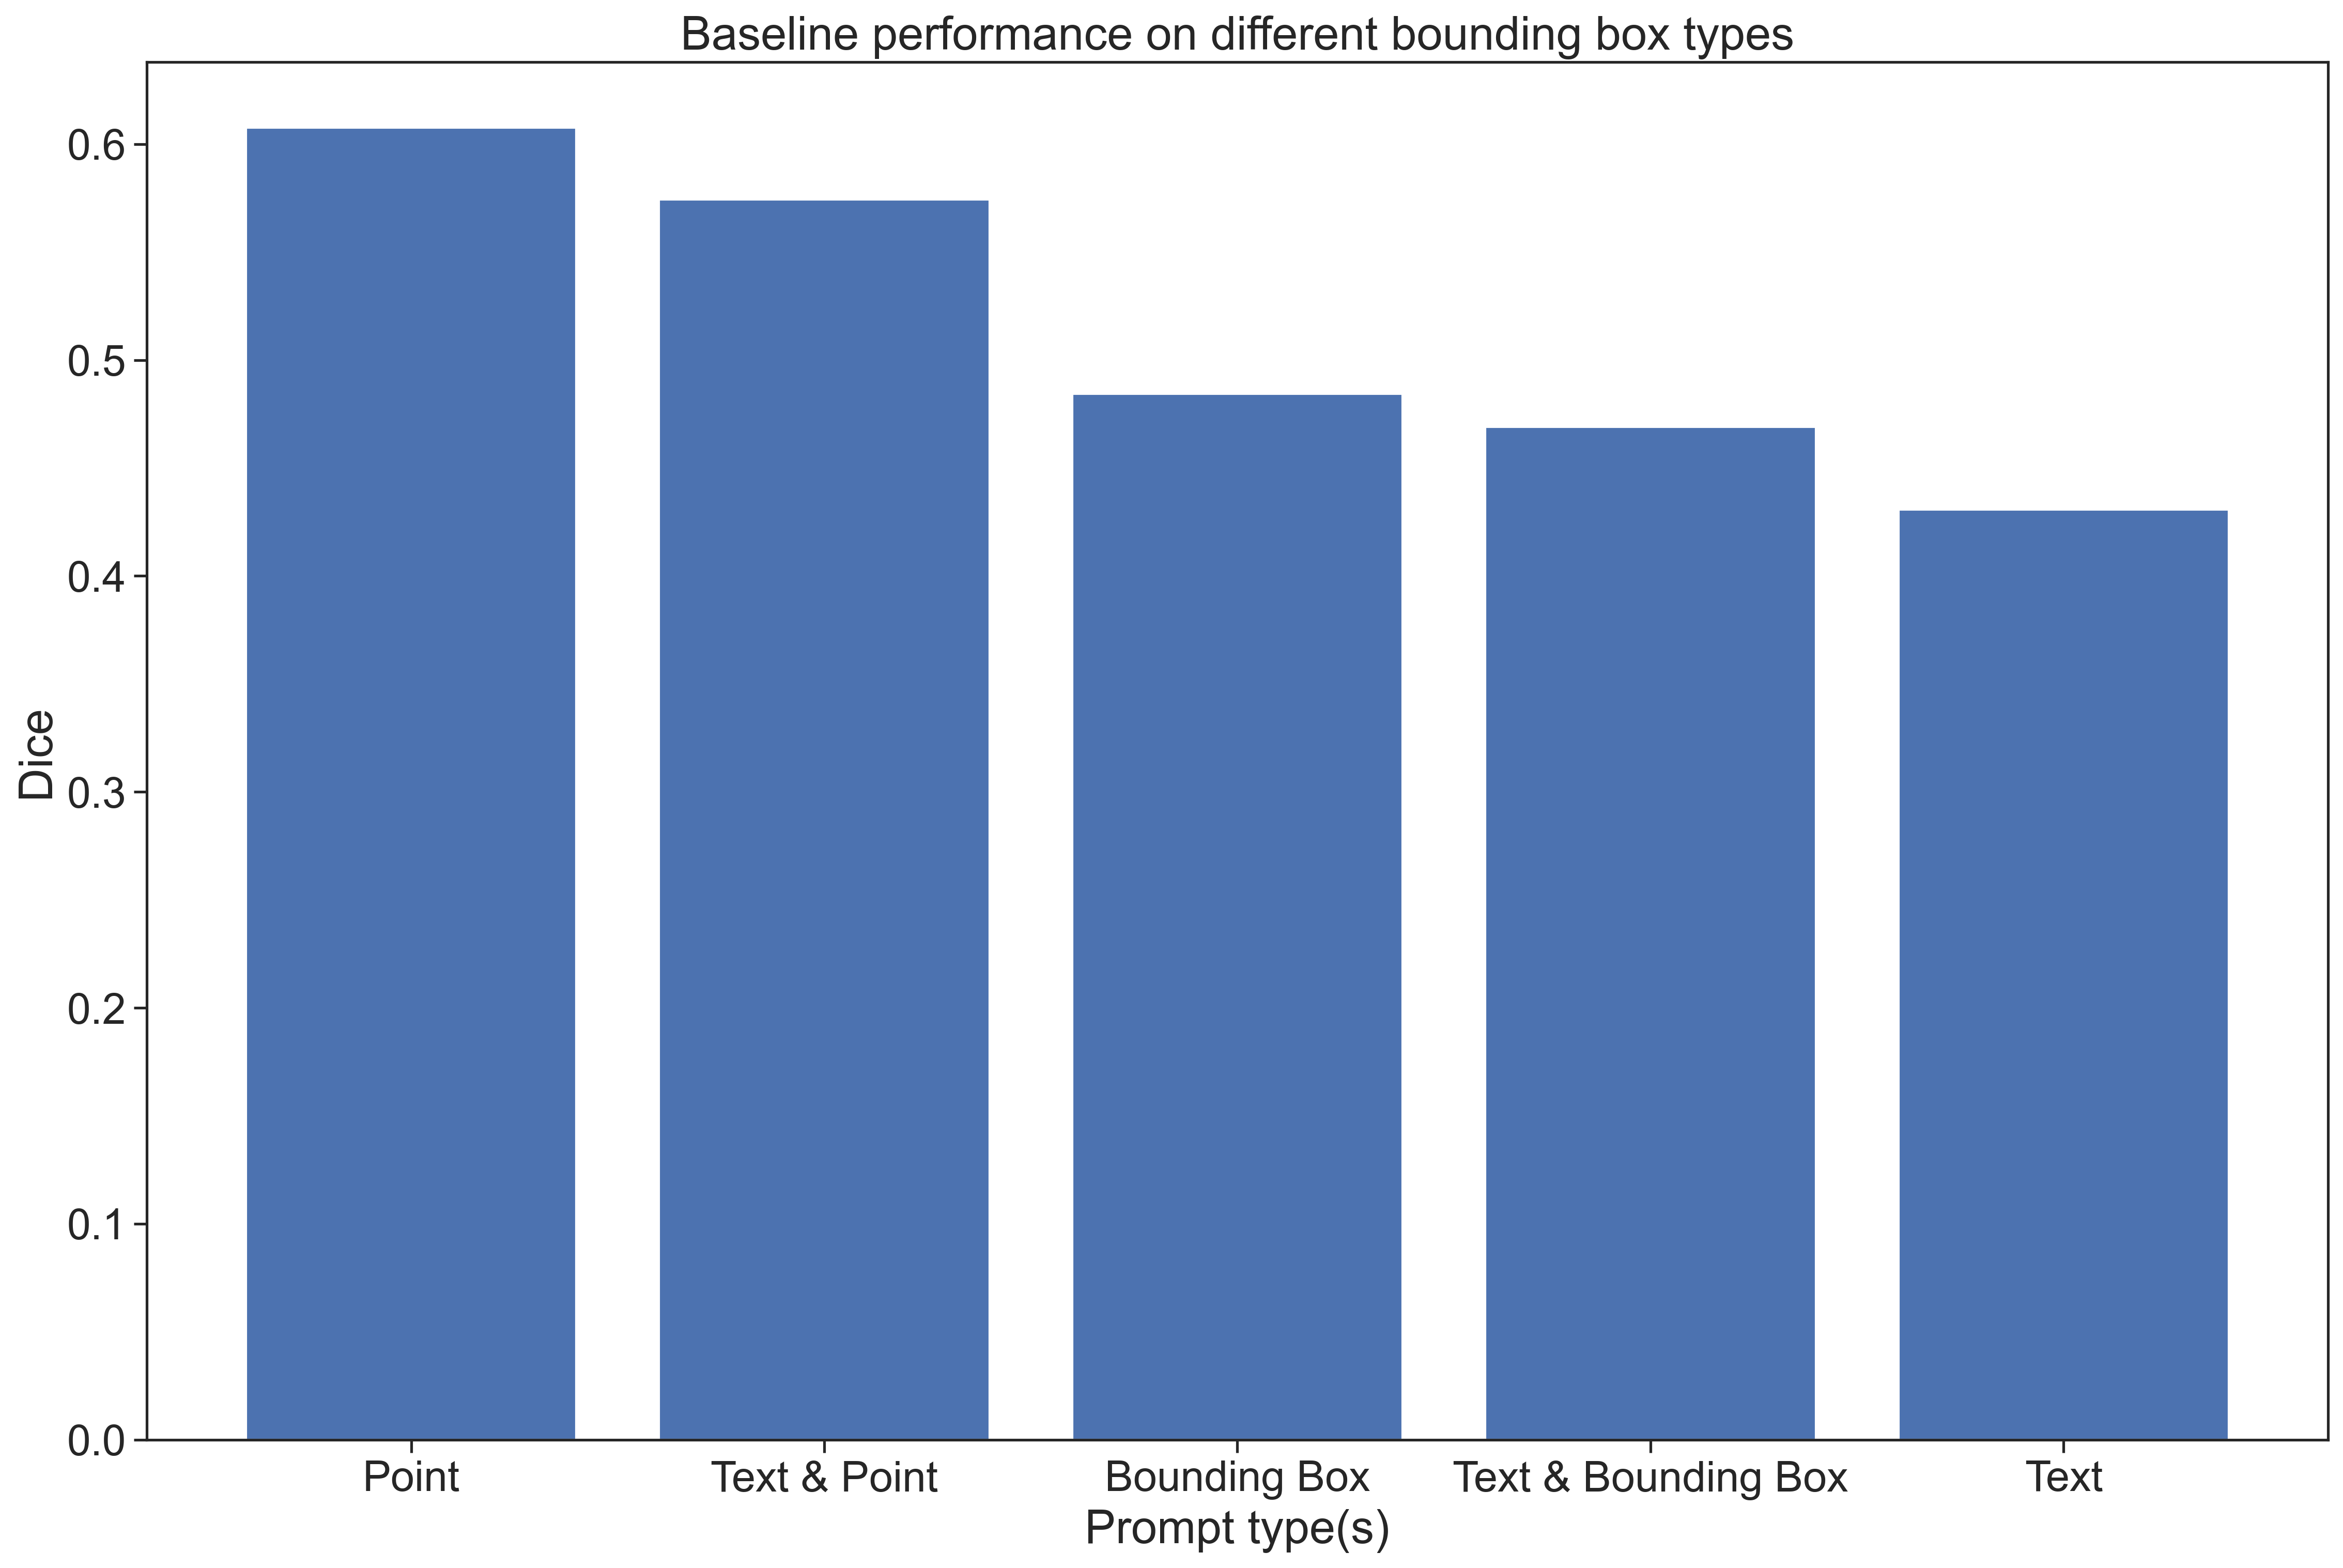

In [11]:
# BASELINE PROMPT TYPE ABLATIONS
# plot the dice scores of different prompt types for each model
base_dices = [(pt, pt_dict['aggregated']['all']) for pt, pt_dict in prompt_ablations['Baseline'].items()]
base_dices = sorted(base_dices, key=lambda x: x[1], reverse=True)
# make a barplot, set ticks to prompt type on the x axis
# also rotate the labels by 30 degrees
fig, ax = plt.subplots(figsize=(15,10))
ax.bar([pt for pt, _ in base_dices], [dice for _, dice in base_dices], )
ax.set_xticklabels([pt for pt, _ in base_dices], rotation=0)
ax.set_xlabel('Prompt type(s)')
ax.set_ylabel('Dice')
plt.title('Baseline performance on different bounding box types')
plt.savefig('../assets/baseline_bounding_box_types.png')
plt.show()

In [12]:
prompt_ablations

{'Baseline': {'Text & Point': {'path': '../results/400_ablations/base_text_point.json',
   'data': {'dice': 0.574426531791687,
    'per_dataset_modality_task_dice': {'MSD_mr_42': {'CT': {},
      'MRI': {'prostate': 0.2924136519432068}},
     'T2-weighted-MRI_mr_42': {'CT': {},
      'MRI': {'prostate': 0.6123359203338623}},
     'promise12_mr_42': {'CT': {}, 'MRI': {'prostate': 0.3799274265766144}},
     'SAML_mr_42': {'CT': {}, 'MRI': {'prostate': 0.2445816993713379}},
     'brats_mr_42': {'CT': {},
      'MRI': {'Enhancing Tumor': 0.23638063669204712,
       'Non-Contrast-Enhancing Tumor Core': 0.15418213605880737,
       'Edema': 0.405407577753067}},
     'amos_mrct_42': {'CT': {},
      'MRI': {'right kidney': 0.9505231380462646,
       'liver': 0.8728427290916443,
       'arota': 0.8999490141868591,
       'left adrenal gland': 0.48565858602523804,
       'pancreas': 0.6717847585678101,
       'esophagus': 0.5676526427268982,
       'gall bladder': 0.5372333526611328,
       'sto

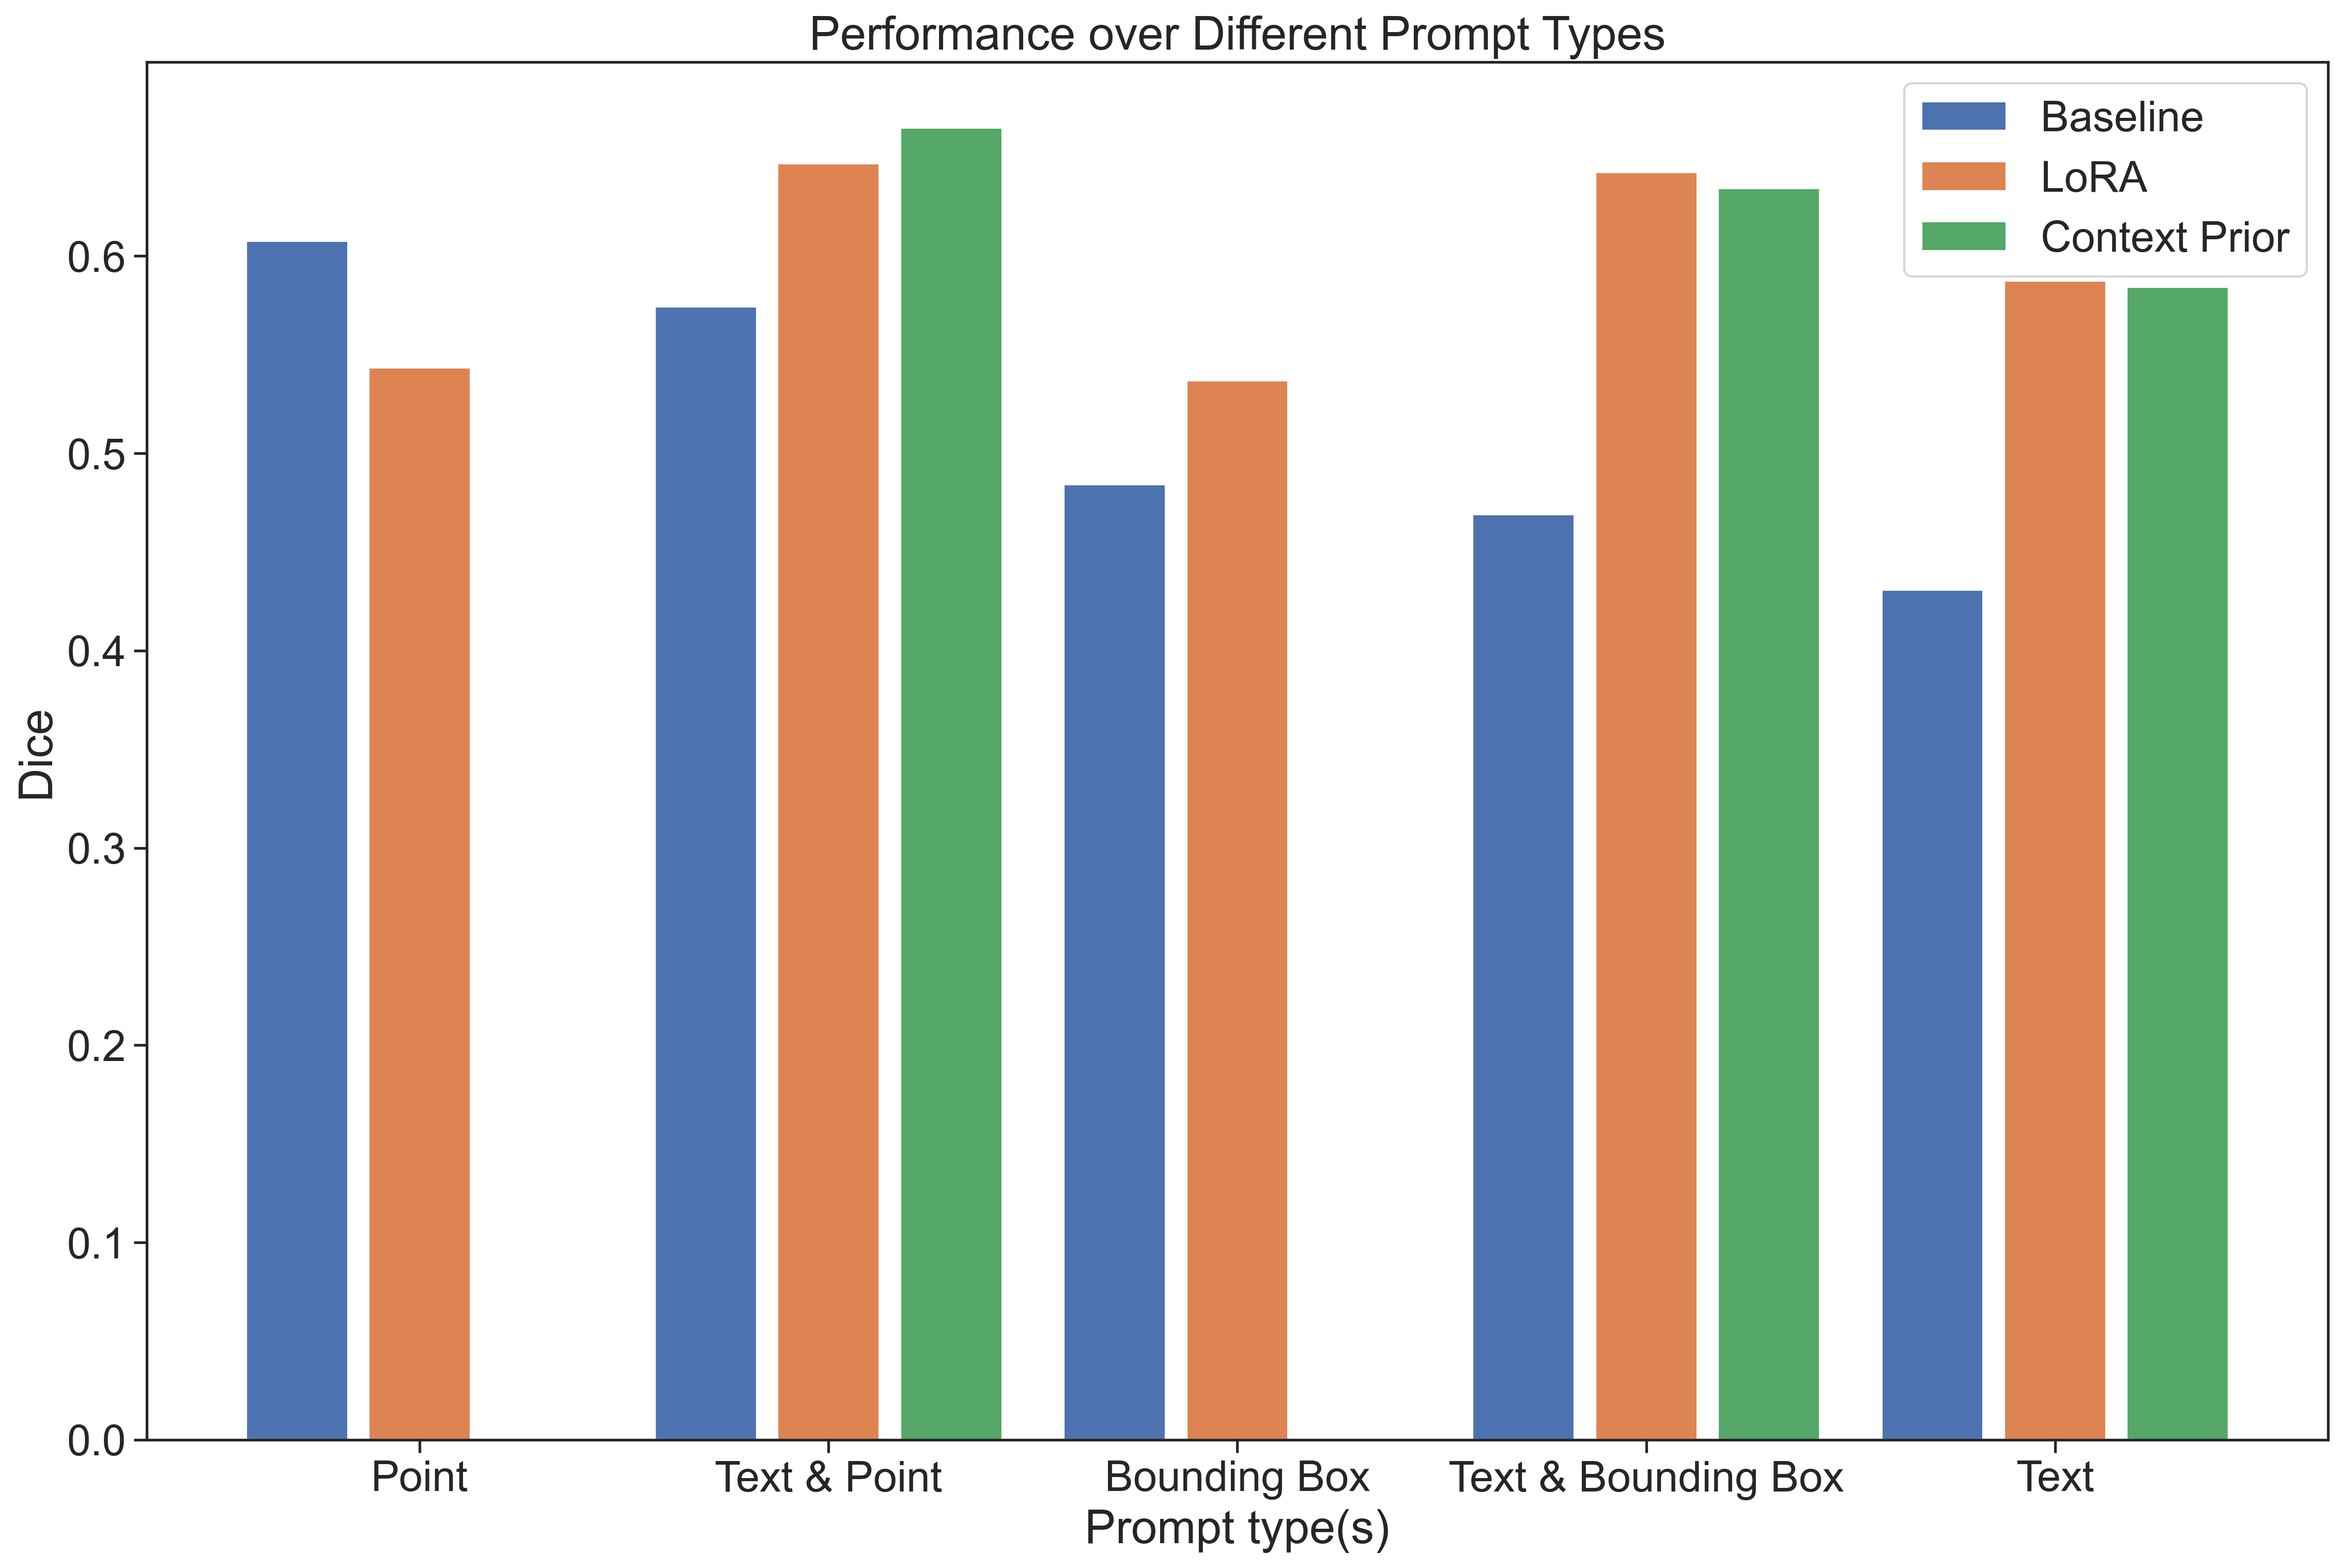

In [13]:
# BASE, CONTEXT, LORA PROMPT TYPE ABLATIONS
# plot the dice scores of different prompt types for each model
order = [bd[0] for bd in base_dices]
fig, ax = plt.subplots(figsize=(15,10))
width = 0.25; step = [-0.3, 0, 0.3]
for idx, model_type in enumerate(['Baseline', 'LoRA', 'Context Prior']):
    dices = []
    for pt in order:
        safeval = prompt_ablations[model_type][pt]['aggregated']['all'] if 'aggregated' in prompt_ablations[model_type][pt] else 0
        dices.append((pt, safeval))
    # make a barplot, set ticks to prompt type on the x axis
    # also rotate the labels by 30 degrees
    ax.bar(np.arange(len(dices))+step[idx], [dice for _, dice in dices], width=width, label=model_type)
    ax.set_ylabel('Dice')
ax.legend()
plt.title('Performance over Different Prompt Types')
ax.set_xticks(np.arange(len(order)))
ax.set_xticklabels(order, rotation=0)
ax.set_xlabel('Prompt type(s)')
plt.savefig('../assets/prompt_type_performance.png')
plt.show()

In [14]:
# 400 bounding box perturbation ablations
bbox_ablations = {
    'Baseline': {
        0: {
            'path': '../results/400_ablations/base_text_bbox.json'
        },
        1: {
            'path': '../results/400_ablations/base_perturb_1.json'
        },
        5: {
            'path': '../results/400_ablations/base_perturb_5.json'
        },
        10: {
            'path': '../results/400_ablations/base_perturb_10.json'
        },
        50: {
            'path': '../results/400_ablations/base_perturb_50.json'
        }
    },
    'Context Prior': {
        0: {
            'path': '../results/400_ablations/context_text_bbox.json'
        },
        1: {
            'path': '../results/400_ablations/context_perturb_1.json'
        },
        5: {
            'path': '../results/400_ablations/context_perturb_5.json'
        },
        10: {
            'path': '../results/400_ablations/context_perturb_10.json'
        },
        50: {
            'path': '../results/400_ablations/context_perturb_50.json'
        }
    },
    'LoRA': {
        0: {
            'path': '../results/400_ablations/lora_text_bbox.json'
        },
        1: {
            'path': '../results/400_ablations/lora_perturb_1.json'
        },
        5: {
            'path': '../results/400_ablations/lora_perturb_5.json'
        },
        10: {
            'path': '../results/400_ablations/lora_perturb_10.json'
        },
        50: {
            'path': '../results/400_ablations/lora_perturb_50.json'
        }
    }
}

In [15]:
# for each ablation experiment, load the corresponding data file
for model_type in bbox_ablations.keys():
    print('processing model type {}'.format(model_type))
    for prompt_type in bbox_ablations[model_type]:
        if not os.path.exists(bbox_ablations[model_type][prompt_type]['path']):
            print('  file not found:',
                  bbox_ablations[model_type][prompt_type]['path'])
            continue
        print('  processing prompt type {}'.format(prompt_type))
        data_path = bbox_ablations[model_type][prompt_type]['path']
        bbox_ablations[model_type][prompt_type]['data'] = load_single_results(
            data_path)
        bbox_ablations[model_type][prompt_type]['aggregated'] = compute_aggregates(
            bbox_ablations[model_type][prompt_type]['data'])

processing model type Baseline
  processing prompt type 0
  processing prompt type 1
  processing prompt type 5
  processing prompt type 10
  processing prompt type 50
processing model type Context Prior
  processing prompt type 0
  processing prompt type 1
  processing prompt type 5
  processing prompt type 10
  processing prompt type 50
processing model type LoRA
  processing prompt type 0
  processing prompt type 1
  processing prompt type 5
  processing prompt type 10
  processing prompt type 50


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/1x/7k25rxt159j8lx18by4r5yhm0000gn/T/ipykernel_44818/186158378.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(pt) for pt, _ in base_dices], rotation=0)


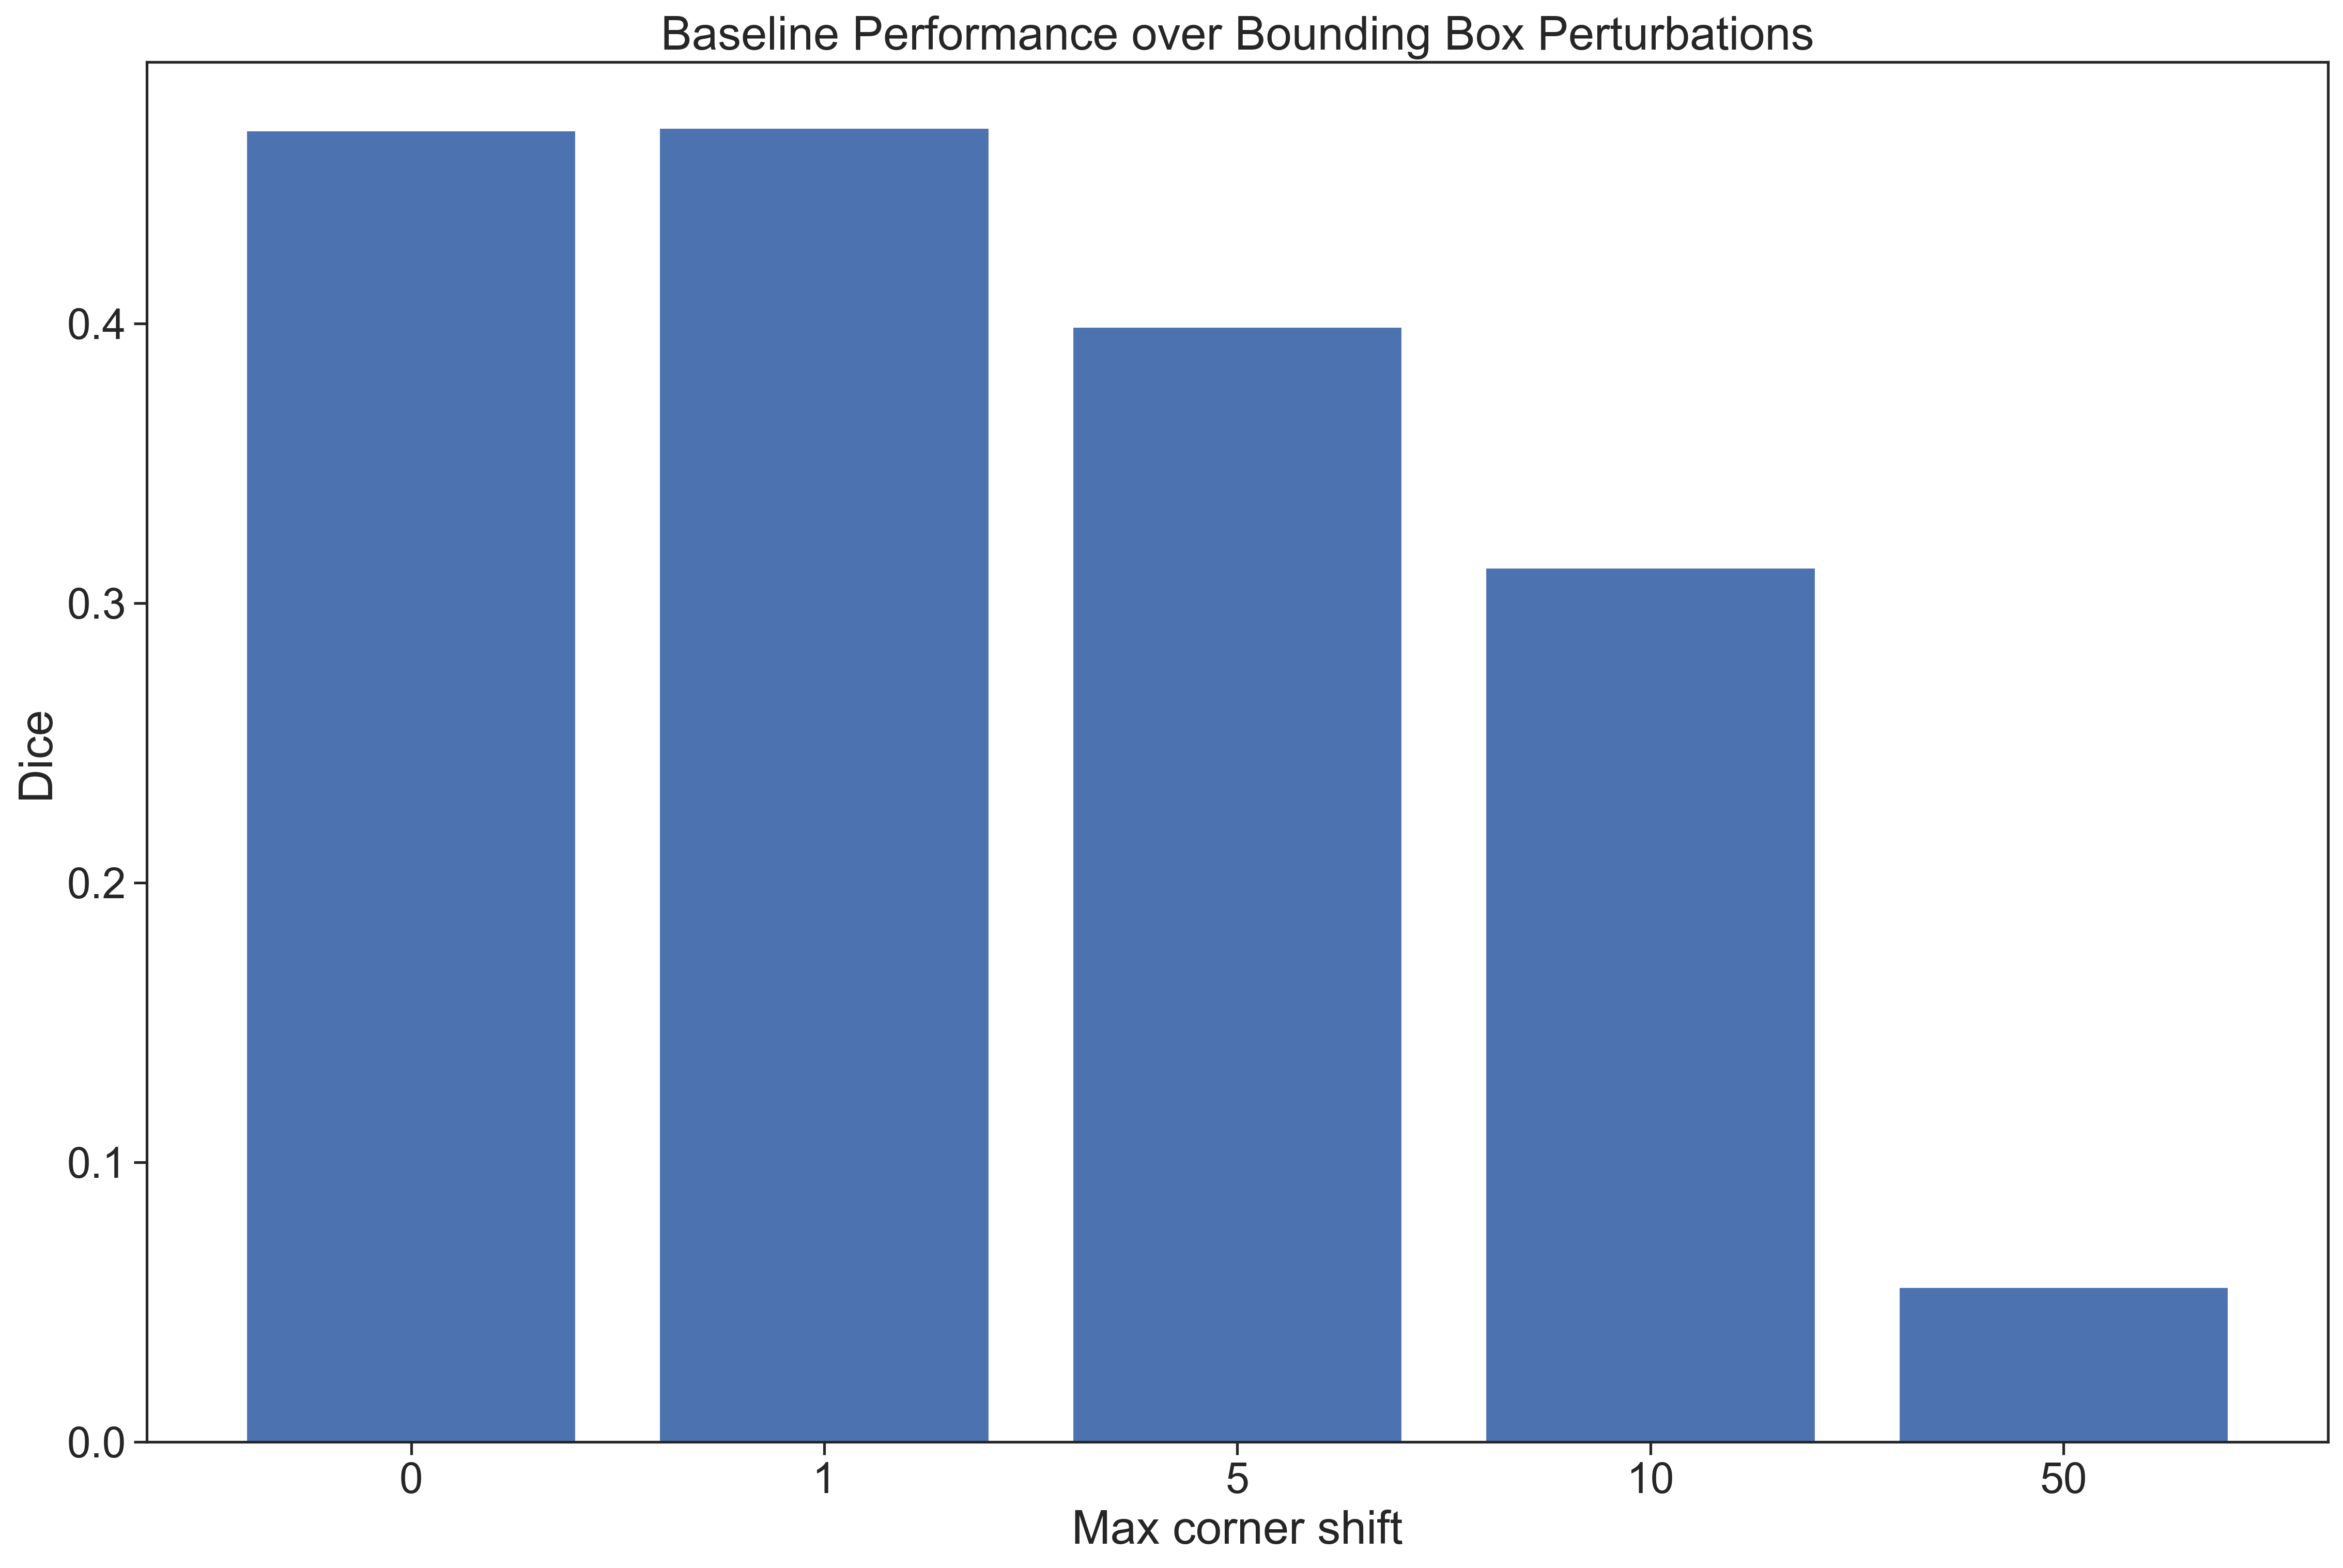

In [16]:
# BASELINE BBOX PERTURBATIONS
# plot the dice scores of different prompt types for each model
base_dices = [(pt, pt_dict['aggregated']['all'])
              for pt, pt_dict in bbox_ablations['Baseline'].items()]
base_dices = sorted(base_dices, key=lambda x: x[0], reverse=False)
# make a barplot, set ticks to prompt type on the x axis
# also rotate the labels by 30 degrees
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar([str(pt) for pt, _ in base_dices], [dice for _, dice in base_dices], )
ax.set_xticklabels([str(pt) for pt, _ in base_dices], rotation=0)
ax.set_xlabel('Max corner shift')
ax.set_ylabel('Dice')
plt.title('Baseline Performance over Bounding Box Perturbations')
plt.savefig('../assets/baseline_perturbations.png')
plt.show()

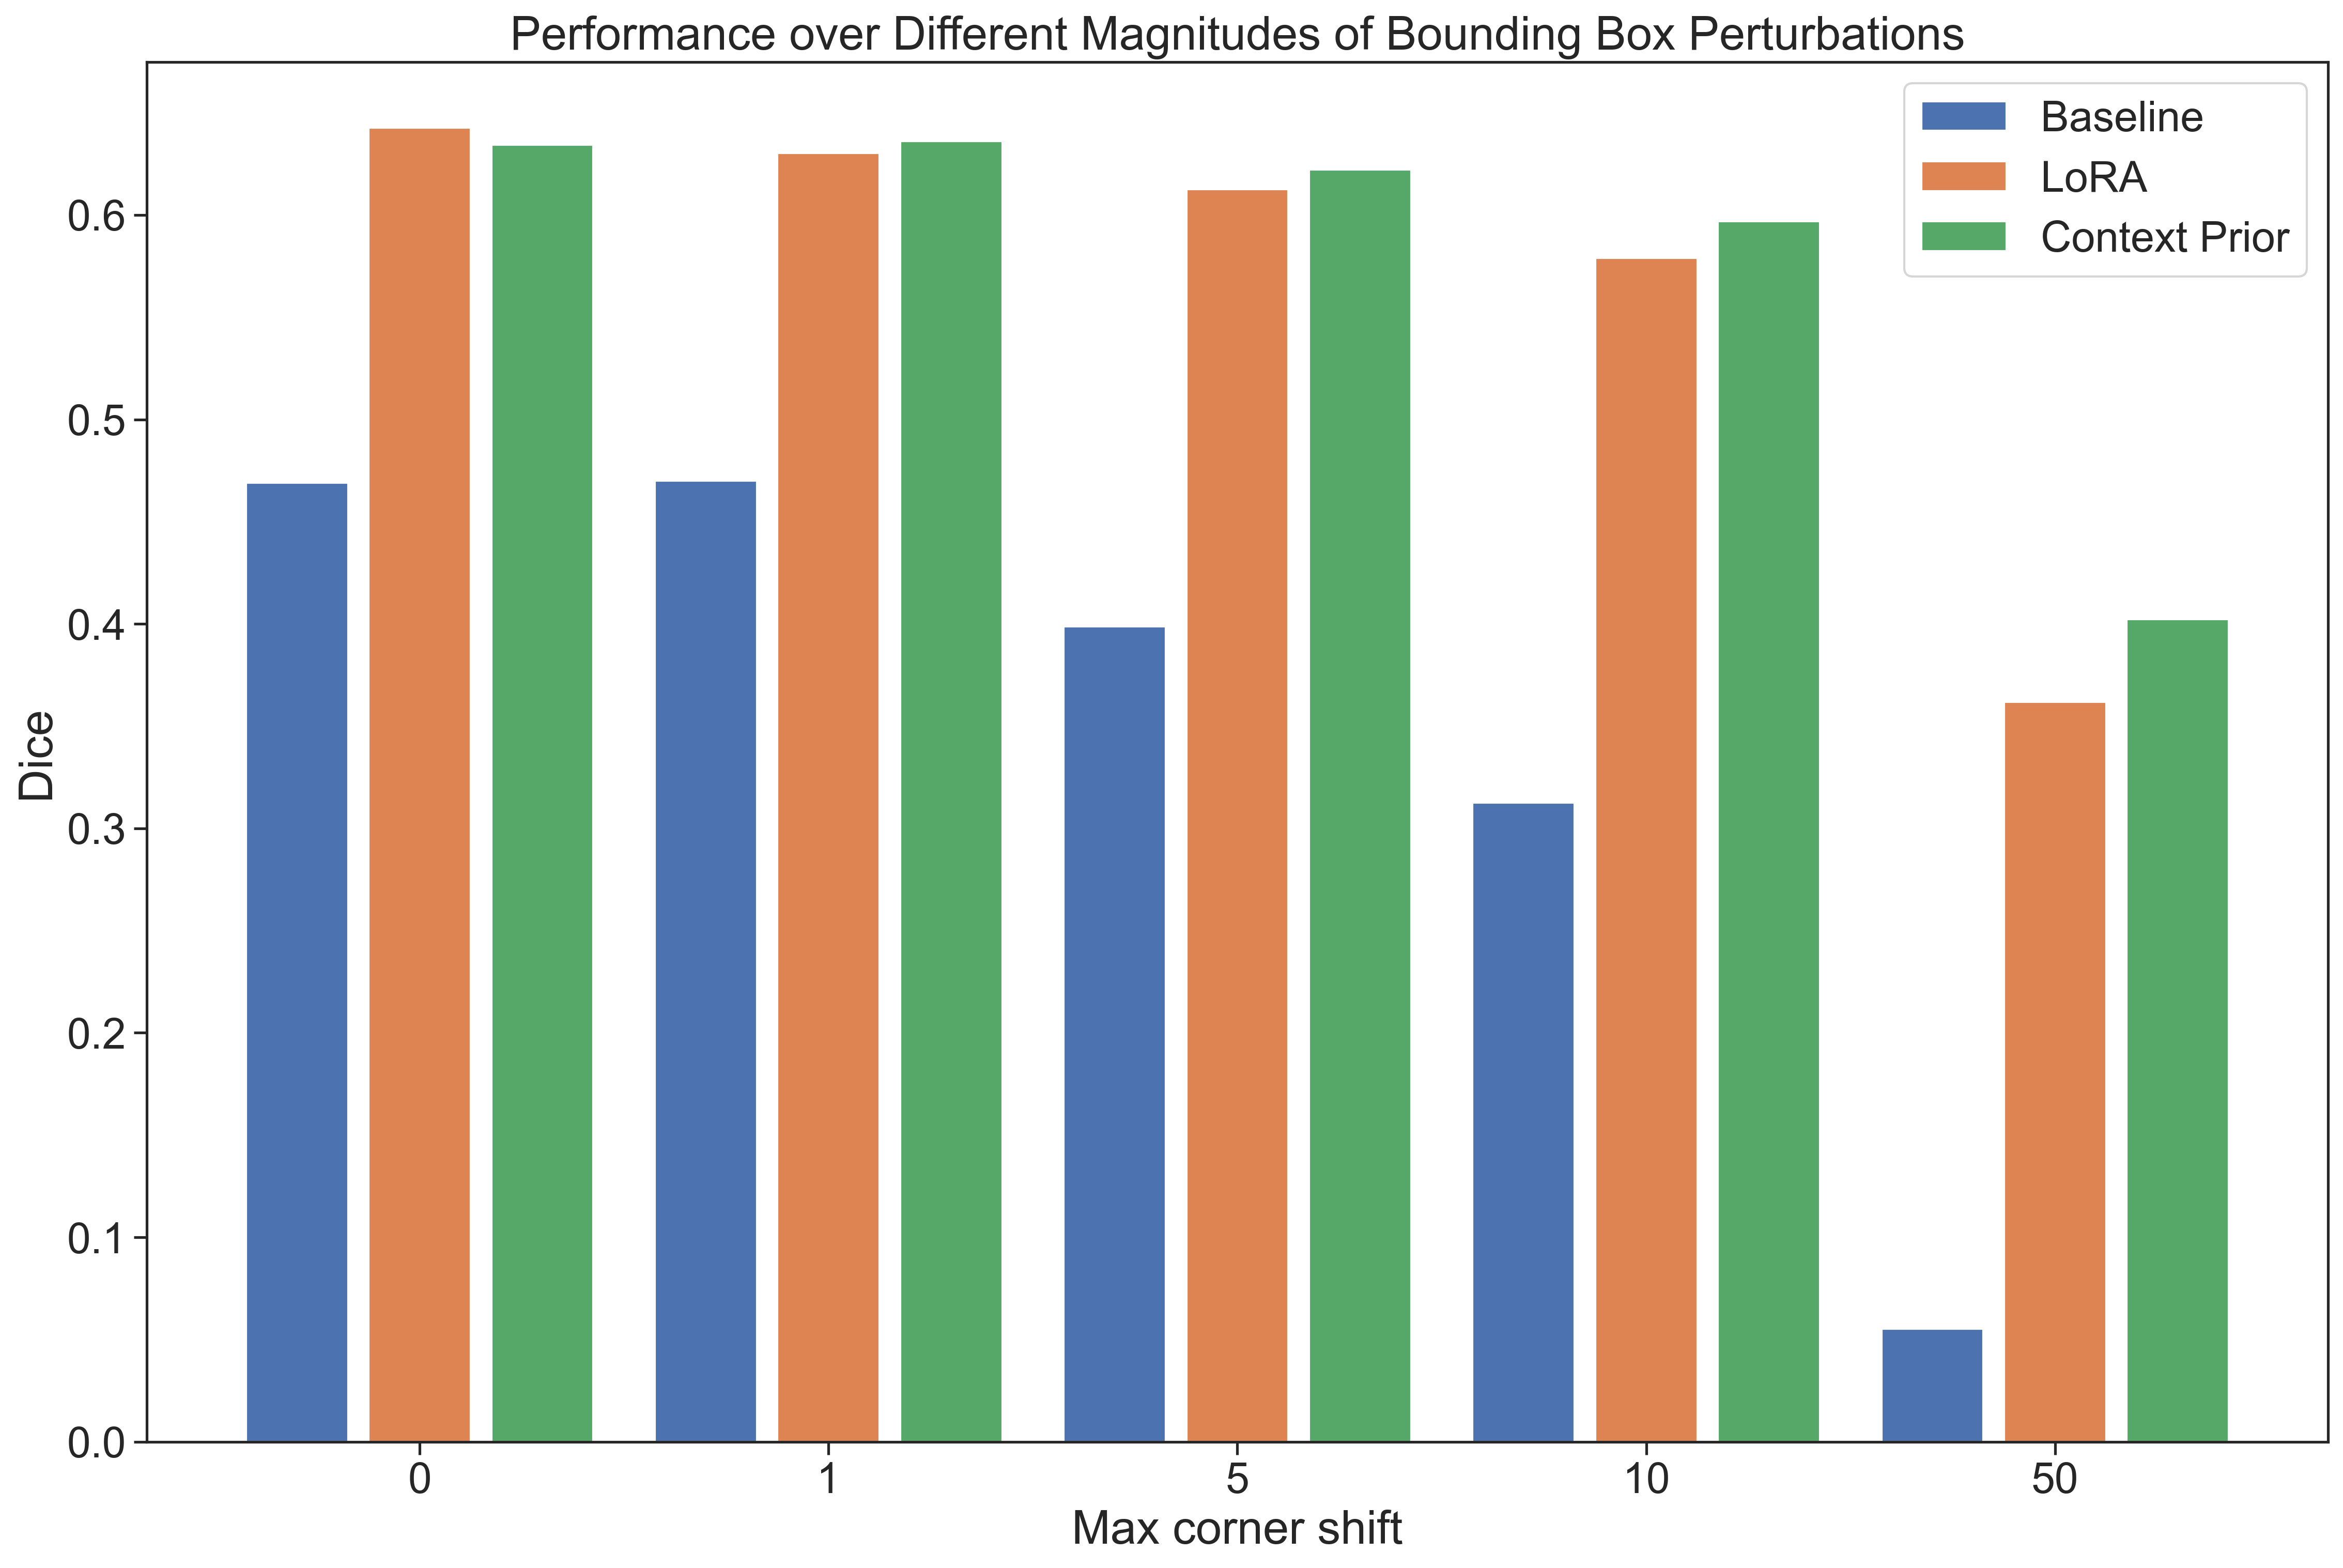

In [19]:
# BASE, CONTEXT, LORA PROMPT TYPE ABLATIONS
# plot the dice scores of different prompt types for each model
order = [bd[0] for bd in base_dices]
fig, ax = plt.subplots(figsize=(15, 10))
width = 0.25
step = [-0.3, 0, 0.3]
for idx, model_type in enumerate(['Baseline', 'LoRA', 'Context Prior']):
    dices = []
    for pt in order:
        safeval = bbox_ablations[model_type][pt]['aggregated']['all'] if 'aggregated' in bbox_ablations[model_type][pt] else 0
        dices.append((pt, safeval))
    # make a barplot, set ticks to prompt type on the x axis
    # also rotate the labels by 30 degrees
    ax.bar(np.arange(len(dices)) +
           step[idx], [dice for _, dice in dices], width=width, label=model_type)
    ax.set_ylabel('Dice')
ax.legend()
plt.title('Performance over Different Magnitudes of Bounding Box Perturbations')
ax.set_xticks(np.arange(len(order)))
ax.set_xticklabels(order, rotation=0)
ax.set_xlabel('Max corner shift')
plt.savefig('../assets/prompt_type_performance.png')
plt.show()

In [18]:
# BASE, CONTEXT, LORA BBOX PERTURBATIONS
prompt_types = ['Text & Point', 'Text & Bounding Box', 'Text', 'Point', 'Bounding Box']
